# Lecture Notes: Basic Image Processing
Before jumping to build powerful and intelligent models for visual recognition it is always important to look at some pixels. Looking at images and pixels and transforming them in various ways gives us often valuable intuitions on how to find things about images, and how to build the algorithms behind intelligent visual recognition systems. We will be using pytorch's Tensors to manipulate images as tensors, and the pillow (PIL) image processing library.

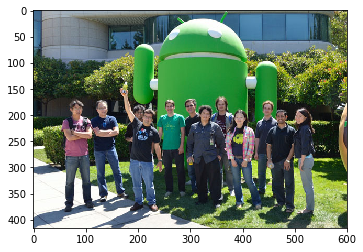

Image type: torch.FloatTensor
Image size: torch.Size([3, 416, 600])


In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline

# pytorch provides a function to convert PIL images to tensors.
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# Read the image from file. Assuming it is in the same directory.
pil_image = Image.open('google_android.jpg')
rgb_image = pil2tensor(pil_image)

# Plot the image here using matplotlib.
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

plot_image(rgb_image)

# Show the image tensor type and tensor size here.
print('Image type: ' + str(rgb_image.type()))
print('Image size: ' + str(rgb_image.size()))

The rgb_image variable contains a torch.FloatTensor of size channels x height x width corresponding to the dimensions of the image. Each entry is a floating-point number between 0 and 1.

## 1. Image channels
We can slice the image into each R, G, and B channels and show them separately:

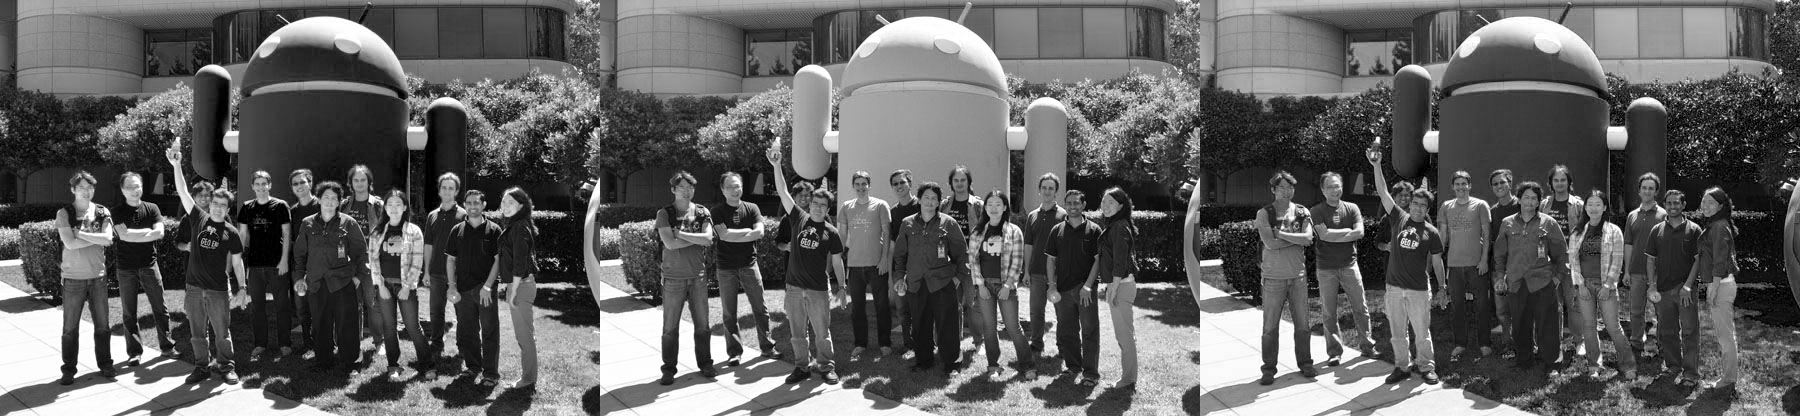

In [2]:
from io import BytesIO
import IPython.display

r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

def show_grayscale_image(tensor):
    # IPython.display can only show images from a file.
    # So we mock up an in-memory file to show it.
    # IPython.display needs a numpy array with channels first.
    # and it also has to be uint8 with values between 0 and 255.
    f = BytesIO()
    a = np.uint8(tensor.mul(255).numpy()) 
    Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data = f.getvalue()))

# Cat concatenates tensors along a given dimension, we choose width here (1), instead of height (0).
show_grayscale_image(torch.cat((r_image, g_image, b_image), 1))

Each image in the above code is a one-channel image (e.g. grayscale image) corresponding to each RGB channel. You can clearly notice the Android figure looks brighter in the Green channel (the one in the middle).

We can try to enhance the green channel in the original image by multiplying this channel by a constant. (and making sure the values do not go above 1, or below 1):

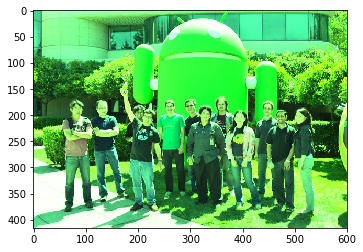

In [3]:
# We need to clone, otherwise both tensors would point to the same object, and we don't want to modify the
# original image as we want to keep working with it later. Always keep this in mind!
image_copy = rgb_image.clone()

# Multiply the green channel by two, clamp the values to the 0-1 range.
image_copy[1] = image_copy[1].mul(2.0).clamp(0.0, 1.0)

# Note: Alternatively we can accomplish the above with an in-place operations.
# Remember that in-place operations in pytorch end with _, not all operations support it.
# but often you want to prefer in-place as you don't need extra memory. See below:
#
# image_copy[1].mul_(2).clamp_(0, 1)
#

# Plot the image_copy.
plot_image(image_copy)
# Try, enhacing the other channels!

## 2. Converting to Grayscale
How do we convert an RGB image to grayscale? A simple way would be to average all three RGB channels. Note the division by 3, since each channel has values between 0 and 1, we want to make sure the resulting grayscale image also has values between 0 and 1.

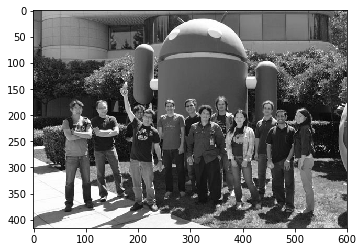

In [4]:
r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

grayscale_image = (r_image + g_image + b_image).div(3.0)

def plot_grayscale_image(tensor):
    plt.figure()
    plt.imshow(tensor.numpy(), cmap = 'gray')
    plt.show()
    
plot_grayscale_image(grayscale_image)

A better way to convert a color RGB image into a grayscale image is using a weighted average. For instance:

$$ \text{gray_image} = 0.4 * \text{red_image} + 0.4 * \text{green_image} + 0.2 * \text{blue_image}$$

Why? To reproduce better how most humans perceive the images. We do not have the same sensitivity for all three channels, the coefficients reflect this. We are considerbly less sensative to blue. Here is a more detailed exposition about this on wikipedia: https://en.wikipedia.org/wiki/Grayscale#Colorimetric_.28luminance-preserving.29_conversion_to_grayscale 

## 3. Other Color Spaces
In addition to RGB images, we can represent images as HSV, where each channel corresponds to Hue, Saturation and Value (~lightness) instead. Other color spaces include: HSV, Lab, YUV, etc. Sometimes representing an image in some of these other ways might be more beneficial for a given analysis. For instance if we want to focus only on Hue and Saturation but we do not care too much about Value. PIL has convenient operations to make this transformations.

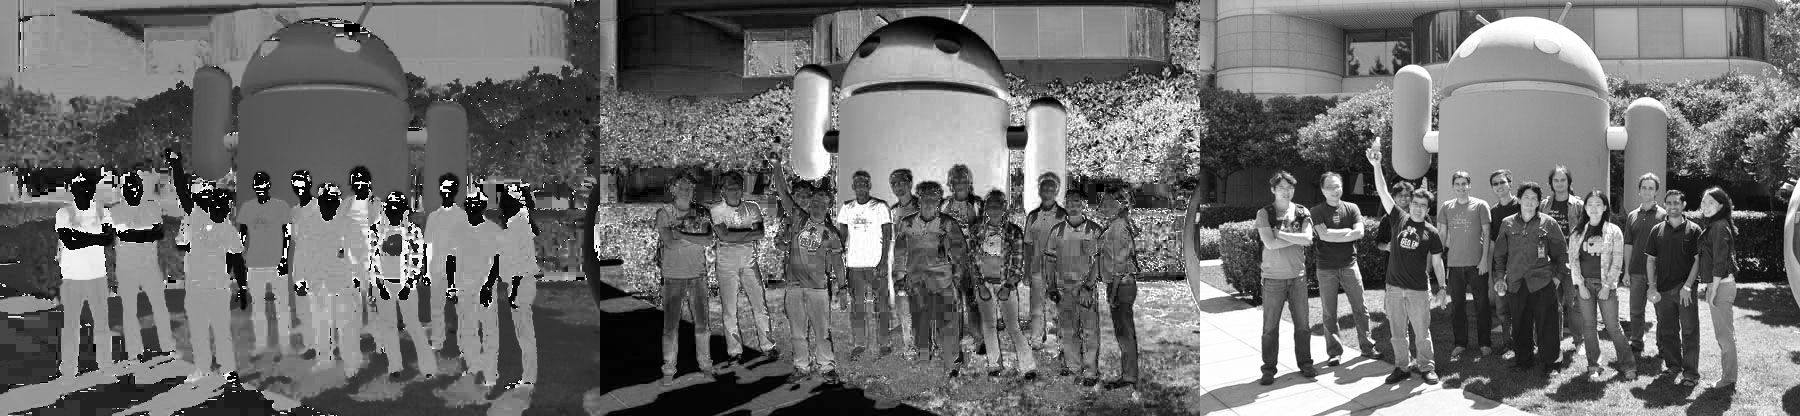

In [5]:
hsv_image = pil2tensor(pil_image.convert('HSV'))

h_image = hsv_image[0]
s_image = hsv_image[1]
v_image = hsv_image[2]

show_grayscale_image(torch.cat((h_image, s_image, v_image), 1))

Notice how the Hue channel tries to output a flat value for regions that are supposed to be the same color (e.g. t-shirts) regardless of luminance. The Saturation channel tries to output higher (brighter) values for regions that have more intense colors (e.g. the Android), and the value channel outputs something similar to the original image. You can also deduce that the RGB color space outputs roughly three different versions of "value" or "luminance". In practice, many modern machine learning and visual recognition models use RGB images directly, and do not take the extra step of converting to other channel spaces because the models are (in a way) robust enough to discover this information on their own.

## 4. Brightness
Making an image brighter is achieved by multiplying the pixels in the image by a scalar bigger than 1 (making sure the values are still between 0 and 1). Conversely, if you multiply the pixels by a scalar between 0 and 1, you make the image darker.

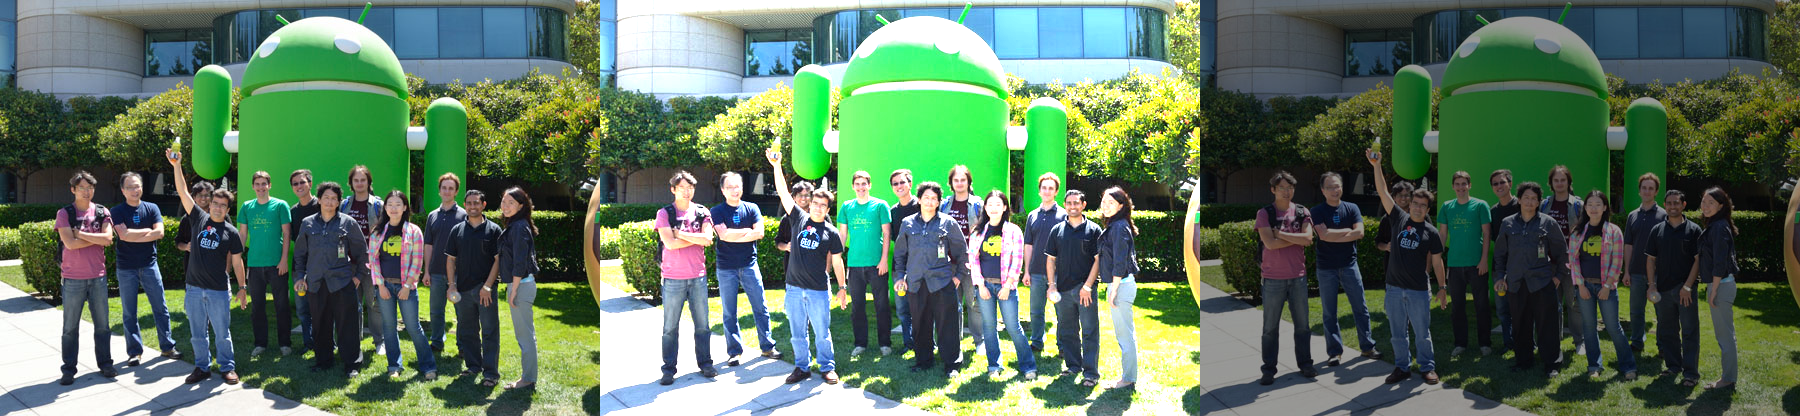

In [6]:
bright_rgb_image = rgb_image.clone()
dark_rgb_image = rgb_image.clone()

# Multiply all elements in the image by 1.8, and then clamp values between 0 and 1.
bright_rgb_image.mul_(1.8).clamp_(0, 1)

# Multiply all elements in the image by 0.6, and then clamp values between 0 and 1.
dark_rgb_image.mul_(0.6).clamp_(0, 1)

def show_image(tensor):
    f = BytesIO()
    a = np.uint8(tensor.mul(255).numpy().transpose(1, 2, 0)) 
    Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data = f.getvalue()))

# Since these are color images (0: channels, 1: height, 2: width), we need to concat in the 2nd dimension. 
show_image(torch.cat((rgb_image, bright_rgb_image, dark_rgb_image), 2))

We could also write three for-loops that go along each dimension of the rgb_image tensor and multiply each value by 1.8. However, modifying each pixel intensity one by one using these three for loops is slow. The efficient way to do this would be to program the three for loops in a lower level language like C/C++. Fortunately pytorch has many efficient tensor operations implemented in C/C++. This means that if we can find a way to implement the above code using functions provided by pytorch we not need to write any C/C++ to obtain good performance. This is why you need to know all the basic tensor operations such as mul, clamp, or div. 

Moreover, if you have a CUDA-capable GPU in your computer. You can move the tensor to the GPU memory by calling rgb_image = rgb_image.cuda(), then without any extra effort, the operations on this tensor will be executed on the GPU. (Note: You need to install pytorch with GPU support if you want to do this).

## 5. Histograms
Histograms are useful because while images can be of different sizes, but histograms can be computed to be of the same size regardless of the image sizes. Additionally we can normalize histograms so they sum to 1, or their $\ell_2$ norm is 1 (euclidean norm, Frobenius norm in matrices). 

/Users/wujibang/Developer/Python/anaconda3/envs/cs6501-crv/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


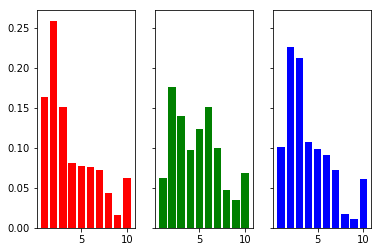

In [7]:
r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

# Compute histograms for each channel.
hist_r = torch.histc(r_image, bins = 10, min = 0.0, max = 1.0)
hist_g = torch.histc(g_image, bins = 10, min = 0.0, max = 1.0)
hist_b = torch.histc(b_image, bins = 10, min = 0.0, max = 1.0)

# Normalize the histograms so that they sum to 1.
hist_r = hist_r.div(hist_r.sum())
hist_g = hist_g.div(hist_g.sum())
hist_b = hist_b.div(hist_b.sum())

# Plot the histograms.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)
ax1.bar(np.linspace(1.0, 10.0, num = 10), hist_r.numpy(), color='r')
ax2.bar(np.linspace(1.0, 10.0, num = 10), hist_g.numpy(), color='g')
ax3.bar(np.linspace(1.0, 10.0, num = 10), hist_b.numpy(), color='b')
fig.show();

## 6. Convolutions

Let's assume a grayscale image (single channel). A convolution is a function that takes an input 2D image $I(x,y)$ and outputs a filtered imaged $I'(x,y)$ such that $I'(x, y) = f(\text{neighborhood of } I(x, y))$. This means that in order to compute the value of the output pixel $I'(x, y)$ we will need not only the input pixel value $I(x, y)$ (as we did for brightness) but also its neighboring pixel values. This is not a strict definition but this is the basic idea.

Most convolution operations we will be using during the course will use an $n\text{x}n$ number of neighboring pixels, and will be of the form:

$$I'(u,v) = \sum_{i=0}^{n-1}\sum_{j=0}^{n-1}{w_{i,j}I(u - \lfloor n / 2 \rfloor + i, v-\lfloor n / 2 \rfloor + j)} + b$$

For the purpose of this lab tutorial $b$ will be zero, so the only parameters of our convolution operations will be the size of our neighborhood region $n$ and the weights $w_{i,j}$. Moreover, for the first few examples here the neighborhod size will be $3\text{x}3$, thus we will be dealing with the following operation to compute the output pixels $I'(u, v)$.

\begin{equation}
\begin{split}
I'(u,v) =\quad  &w_{0,0}I(u - 1, v - 1)\quad  &+\quad &w_{0,1}I(u - 1, v)\quad &+\quad &w_{0,2}I(u - 1, v + 1) \quad+ \\
          &w_{1,0}I(u, v - 1)\quad  &+\quad &w_{1,1}I(u, v)\quad &+\quad &w_{1,2}I(u, v + 1) \quad+ \\
          &w_{2,0}I(u + 1, v - 1)\quad  &+\quad &w_{2,1}I(u + 1, v)\quad &+\quad &w_{2,2}I(u + 1, v + 1) \quad+
\end{split}
\end{equation}

We are effectively computing a sliding window as illustrated here:

<img src="animation.gif" style="width:520px"/>

In practice, there are various ways of making the convolution operations faster by realizing that some computations are shared by consecutive windows, or by sacrificing memory and expressing the convolution as a single matrix multiplication, GPU acceleration is also possible and fortunately all of these are already implemented in pytorch. Convolutions are essential to obtain information from images as well as to apply many common effects to images like blurring, sharpening, etc. In pytorch we can use F.conv2d function to an input image.

Most image processing libraries implement a convolution operation, they are also referred to as image filtering operations in some libraries including PIL (see here http://pillow.readthedocs.io/en/3.4.x/reference/ImageFilter.html). However, here we will use pytorch's convolution operation. First we will run a convolution on the red channel of the image using a kernel of size 3x3 where all the entries are 1.0 / 9.0.

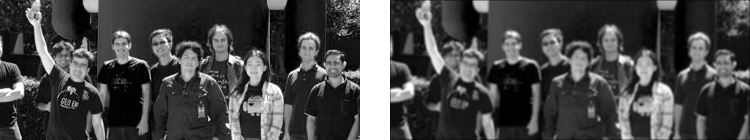

In [8]:
# The input is just a section of the red channel image.
# We will take the pixels between rows 140:280 and columns 140:500.
input_image = r_image[140:280, 140:500]

# The kernel is a 3x3 matrix that computes the average around the pixel.
kv = 1.0 / 9.0
blur_weights = torch.Tensor([[kv, kv, kv],
                        [kv, kv, kv],
                        [kv, kv, kv]])

# This is a hack, do not worry about the details of this implementation. 
# We will learn the meaning of nn.functional, and autograd.Variable later in the class.
# The reason for unsqueezes is because the F.conv2d function is very general, and works
# for multiple images at a time, and multiple channels, and for multiple kernels at a time.
def SingleChannelConvolution(input_image, kernel):
    import torch.nn.functional as F
    from torch.autograd import Variable
    output = F.conv2d(Variable(input_image.unsqueeze(0).unsqueeze(0)), 
                      Variable(kernel.unsqueeze(0).unsqueeze(0)), padding = 1)
    return output.data.squeeze()

# Execute the convolution operation
output = SingleChannelConvolution(input_image, blur_weights)

# Display the output.
padder = torch.ones(input_image.size(0), 30) # Just to leave some space between images.
show_grayscale_image(torch.cat((input_image, padder, output), 1))

Now here are other filters that highlight vertical and horizontal edges in the input. These are also sometimes referred to as Sobel operators, and they are also finite differences that approximate the gradients of the image (This is the equivalent to taking a derivative of a function, except that here we have 2D functions in the discrete domain).

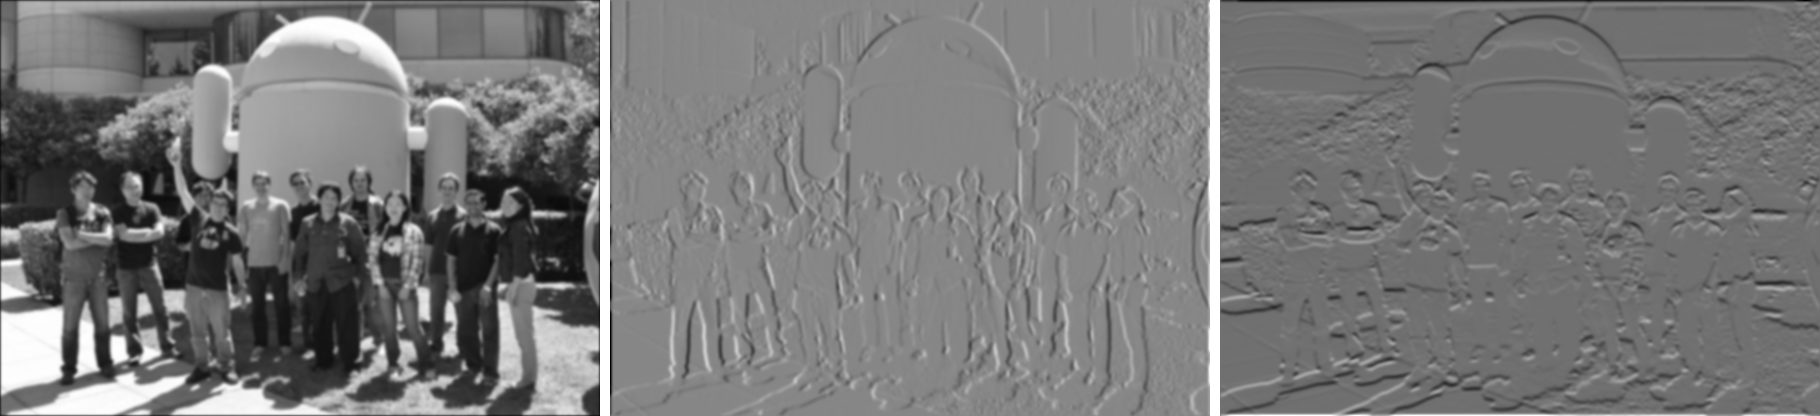

In [9]:
# The input is the green channel image after a few rounds of blurring.
input_image = SingleChannelConvolution(g_image, blur_weights)
input_image = SingleChannelConvolution(input_image, blur_weights)
input_image = SingleChannelConvolution(input_image, blur_weights)

# The kernel is a 3x3 matrix that computes the Sobel operator.
# See https://en.wikipedia.org/wiki/Sobel_operator
weights = torch.Tensor([[1.0, 0.0, -1.0],
                        [2.0, 0.0, -2.0],
                        [1.0, 0.0, -1.0]])

# Execute the convolution operation for the weights and transposed weights.
output1 = SingleChannelConvolution(input_image, weights)
output2 = SingleChannelConvolution(input_image, weights.t())

# Make sure the images are still between 0 and 1.
output1 = (output1 - output1.min()).div(output1.max() - output1.min())
output2 = (output2 - output2.min()).div(output2.max() - output2.min())

# Display the output.
padder = torch.ones(input_image.size(0), 10) # Just to leave some space between images.
show_grayscale_image(torch.cat((input_image, padder, output1, padder, output2), 1))


We could also apply convolutions channel by channel and reconstruct the original image by merging the outputs for each convolution. We could also apply a different kernel to each channel. In fact the kernel matrix could also be an image itself. We will illustrate this below.

output1 torch.Size([1, 391, 579])
output2 torch.Size([1, 391, 579])
output3 torch.Size([1, 391, 579])
output torch.Size([3, 391, 579])
rgb_image torch.Size([3, 416, 600])


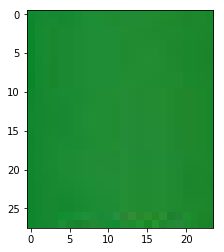

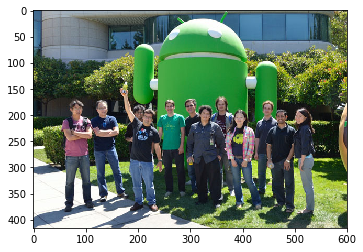

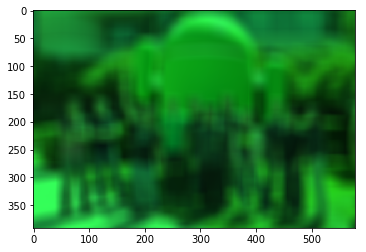

In [10]:
# Crop a patch from the image itself to use as convolutional filters.
kernel_patch = rgb_image[:, 142:170, 436:460]

output1 = SingleChannelConvolution(rgb_image[0], kernel_patch[0])
output2 = SingleChannelConvolution(rgb_image[1], kernel_patch[1])
output3 = SingleChannelConvolution(rgb_image[2], kernel_patch[2])

# Remember that unsqueeze adds a dummy dimension at the beginning of the tensor.
print('output1', output1.unsqueeze(0).size()) 
print('output2', output2.unsqueeze(0).size())
print('output3', output3.unsqueeze(0).size())

output_image = torch.cat((output1.unsqueeze(0), 
                          output2.unsqueeze(0),
                          output3.unsqueeze(0)), 0)

output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

print('output', output_image.size())
print('rgb_image', rgb_image.size())

plot_image(kernel_patch)
plot_image(rgb_image)
plot_image(output_image)

Here is another example. Here we pick a patch from the leg of a person and we convolve this patch with the original image. By now you probably already guessed that filtering (or convolving) the image with a given patch enhances the parts of the image that are similar to the given filter (weight matrix).

output1 torch.Size([1, 369, 577])
output2 torch.Size([1, 369, 577])
output3 torch.Size([1, 369, 577])
output torch.Size([3, 369, 577])
rgb_image torch.Size([3, 416, 600])


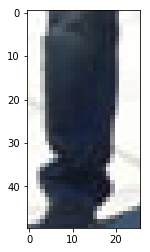

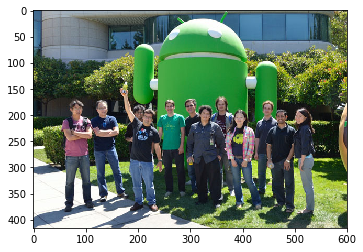

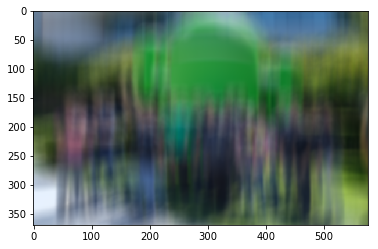

In [11]:
# Crop a patch from the image itself to use as convolutional filters.
kernel_patch = rgb_image[:, 330:380, 58: 84]

output1 = SingleChannelConvolution(rgb_image[0], kernel_patch[0])
output2 = SingleChannelConvolution(rgb_image[1], kernel_patch[1])
output3 = SingleChannelConvolution(rgb_image[2], kernel_patch[2])

# Remember that unsqueeze adds a dummy dimension at the beginning of the tensor.
print('output1', output1.unsqueeze(0).size()) 
print('output2', output2.unsqueeze(0).size())
print('output3', output3.unsqueeze(0).size())

output_image = torch.cat((output1.unsqueeze(0), 
                          output2.unsqueeze(0),
                          output3.unsqueeze(0)), 0)

output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

print('output', output_image.size())
print('rgb_image', rgb_image.size())

plot_image(kernel_patch)
plot_image(rgb_image)
plot_image(output_image)

The main purpose of the above two examples is to show you an important behavior of convolution operators. They generally highlight the patterns in the image that resemble the kernel matrix itself. e.g. the sobel operators look like vertical or horizontal edges if you render them as images, the green patch matrix in the first example highlighted the green areas of the image, and the leg example highlighted leg-like structures.

## Lab assignment

The purpose of this lab is to make sure you have the pytorch environment installed and running, and familiarize yourself with some basic image processing routines. In addition to following the above tutorial, here are the items you have to submit.

- [2pts] Convert an image to HSV and write code that can reduce the saturation channel for a given image by half and show the input and output (You might need to convert back to RGB before showing the image). This operation is basic and instagram, as well as many other populars apps have it.<br/><br/>

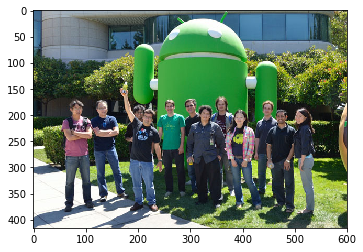

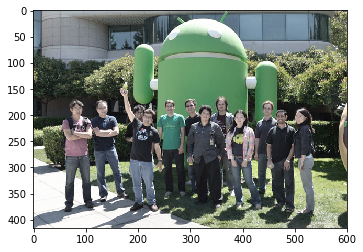

In [12]:
pil_image = Image.open('google_android.jpg')
input_image = pil2tensor(pil_image)
plot_image(input_image)
hsv_image = pil2tensor(pil_image.convert('HSV'))
# reduce the saturation channel for a given image by half
hsv_image[1] = hsv_image[1]/2.0
import matplotlib

def plot_hsv_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    tensor2np = tensor.numpy().transpose(1, 2, 0)
    hsv_image_rgb = matplotlib.colors.hsv_to_rgb(tensor2np)
    plt.imshow(hsv_image_rgb)
    plt.show()

plot_hsv_image(hsv_image)

- [1pts] In the last example of this tutorial, when we convolved the android image with a leg patch. Why did the output image and the input rgb_image have different width and height?. What is the relationship between these two sizes?<br/><br/>

Because the convolution padding is explictly set as 1. The relationship between orginial size $s_1$ and convolved size $s_2$ on each dimension should be $$s_1- w +2\cdot p + 1 = s_2$$, where $w$ is the kernel window size, $p$ in this case is the padding set on both side of the image 

- [1pts] Convolve the image with other different patches and show any interesting effect.<br/><br/>

output1 torch.Size([1, 369, 573])
output2 torch.Size([1, 369, 573])
output3 torch.Size([1, 369, 573])
output torch.Size([3, 369, 573])
rgb_image torch.Size([3, 416, 600])


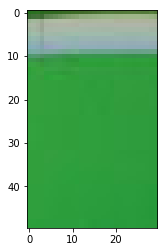

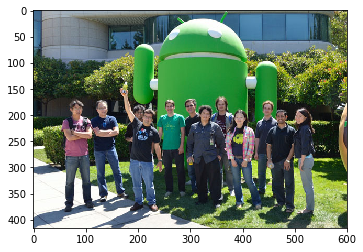

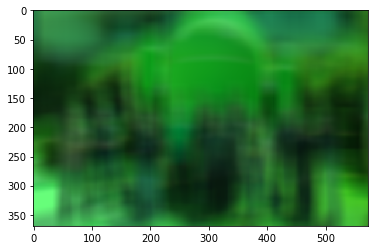

In [16]:
# Crop a patch from the image itself to use as convolutional filters.
kernel_patch = rgb_image[:, 80:130, 300: 330]

output1 = SingleChannelConvolution(rgb_image[0], kernel_patch[0])
output2 = SingleChannelConvolution(rgb_image[1], kernel_patch[1])
output3 = SingleChannelConvolution(rgb_image[2], kernel_patch[2])

# Remember that unsqueeze adds a dummy dimension at the beginning of the tensor.
print('output1', output1.unsqueeze(0).size()) 
print('output2', output2.unsqueeze(0).size())
print('output3', output3.unsqueeze(0).size())

output_image = torch.cat((output1.unsqueeze(0), 
                          output2.unsqueeze(0),
                          output3.unsqueeze(0)), 0)

output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

print('output', output_image.size())
print('rgb_image', rgb_image.size())

plot_image(kernel_patch)
plot_image(rgb_image)
plot_image(output_image)

- [1pts] Convolve any other image of your choice with other different patches and show any interesting effect.<br/><br/>

output1 torch.Size([1, 431, 725])
output2 torch.Size([1, 431, 725])
output3 torch.Size([1, 431, 725])
output torch.Size([3, 431, 725])
rgb_image torch.Size([3, 478, 752])


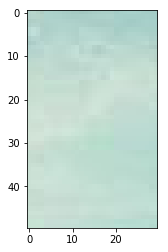

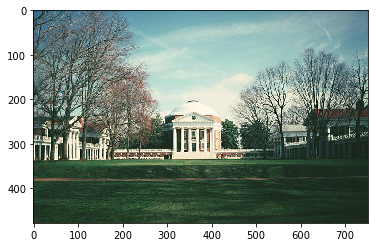

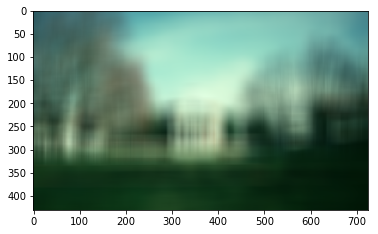

In [18]:
pil_image = Image.open('test/distant.jpg')
rgb_image = pil2tensor(pil_image)
# Crop a patch from the image itself to use as convolutional filters.
kernel_patch = rgb_image[:, 80:130, 300: 330]

output1 = SingleChannelConvolution(rgb_image[0], kernel_patch[0])
output2 = SingleChannelConvolution(rgb_image[1], kernel_patch[1])
output3 = SingleChannelConvolution(rgb_image[2], kernel_patch[2])

# Remember that unsqueeze adds a dummy dimension at the beginning of the tensor.
print('output1', output1.unsqueeze(0).size()) 
print('output2', output2.unsqueeze(0).size())
print('output3', output3.unsqueeze(0).size())

output_image = torch.cat((output1.unsqueeze(0), 
                          output2.unsqueeze(0),
                          output3.unsqueeze(0)), 0)

output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

print('output', output_image.size())
print('rgb_image', rgb_image.size())

plot_image(kernel_patch)
plot_image(rgb_image)
plot_image(output_image)

<div style="font-size:0.8em;color:#888;text-align:center;padding-top:20px;">Vicente Ordonez, 2017 <br/>If you find any errors or omissions in this material please contact me at vicente@virginia.edu